In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt

In [2]:
import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2])

In [4]:
import pickle

PF_SIZE=500

base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")

fixed_shrk_name = 'cov2Para'
opt_shrk_name = 'cov2Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_cov2Para_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\cov2Para_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

In [30]:
X_idces = np.where(rets_full.isna().sum() < 20)[0]
X = rets_full.iloc[:, X_idces]
X = X.fillna(X.median())
X.index = pd.to_datetime(X.index, format="%Y%m%d")

In [34]:
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)

In [37]:
X_standardized.std(axis=0)

PERMNO
10145    1.0
10516    1.0
10866    1.0
10874    1.0
10890    1.0
        ... 
73139    1.0
77730    1.0
78044    1.0
83601    1.0
84129    1.0
Length: 278, dtype: float64

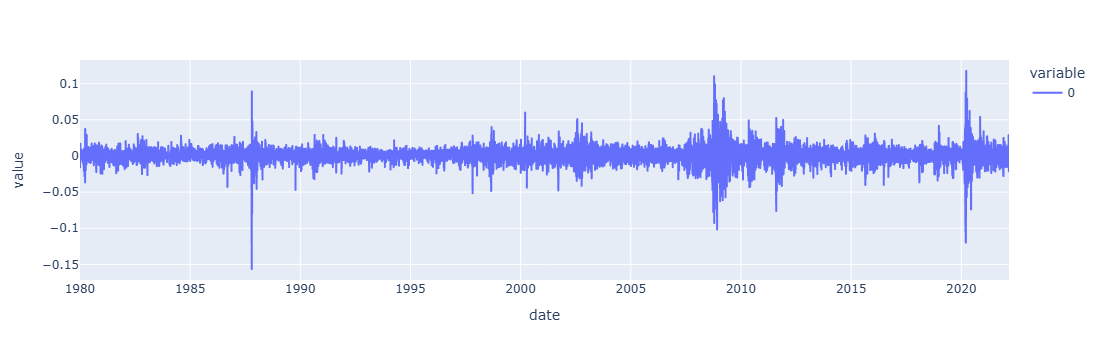

In [47]:
ew_index_returns = X.mean(axis=1)
px.line(ew_index_returns)

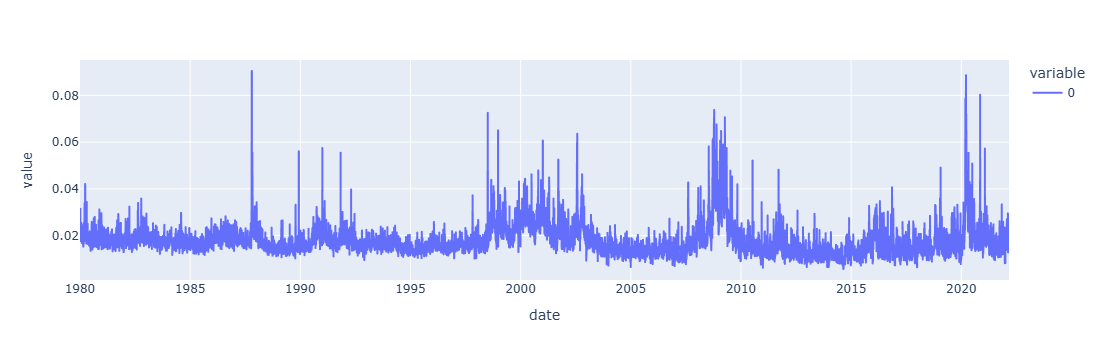

In [49]:
ew_index_volas = X.std(axis=1)
px.line(ew_index_volas)

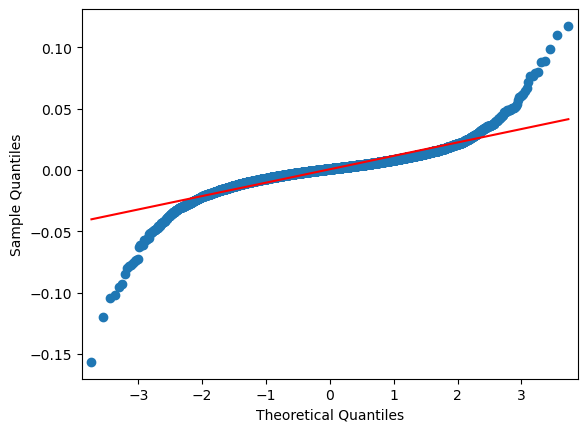

In [51]:
from statsmodels.graphics.gofplots import qqplot
qqplot_data = qqplot(ew_index_returns, line='s').gca().lines

In [112]:
from sklearn.decomposition import PCA

In [287]:
X_sub_demeaned = (X.iloc[0:5000, ] - X.iloc[0:5000, ].mean()) / X.iloc[0:5000, ].std()

In [301]:
# let's fit PCA on the first half of the data

pca = PCA(n_components=5, svd_solver="full")
pca.fit( X_sub_demeaned )

PCA(n_components=5, svd_solver='full')

In [280]:
pca.singular_values_[0:5]

array([9.6851006])

In [281]:
X.shape

(10633, 278)

### manual PCA using eigendecomp of covmat

In [266]:
X_sub_demeaned = (X.iloc[0:5000, ] - X.iloc[0:5000, ].mean()) / X.iloc[0:5000, ].std()

In [267]:
S = 1/X_sub_demeaned.shape[0] * X_sub_demeaned.T @ X_sub_demeaned

#### Singular values of X are linked to the eigenvalues of the data covariance matrix S 
Makes sense, as S = 1/n * X.T * X; Hence sing. values of X need to be squared and divided by N aswell

In [268]:
eigenvalues, eigenvectors = np.linalg.eigh(S)

In [269]:
eigenvalues[-5:] 

array([ 2.68869585,  3.83023891,  4.43590064,  6.56935509, 51.23519464])

In [270]:
U, SingVals, Vh = np.linalg.svd(X_sub_demeaned)

In [271]:
SingVals[0:5]**2 / X.shape[0]

array([24.09253957,  3.08913528,  2.08591208,  1.80110924,  1.26431668])

#### Let us look at the lower dimensional projections of some new datapoints

In [305]:
xnew_demeaned = (X.iloc[6000:6001, :] - X.iloc[0:5000, ].mean()) / X.iloc[0:5000, ].std() #xnew is of dimension 1 x D

In [306]:
xnew_demeaned.shape

(1, 278)

The coordinates of the new input vector (demeaned by mean and std of training set) **in the principal subspace** is given by multiplying the right singular components with the new vector, or the CovMat Eigenvectors with the new vector.

To get the lower dim. Representation of the vector, multiply the (here 5) coordinates with the first 5 principal components.

In [307]:
pca.transform(xnew_demeaned) # coordinates of xnew in the new basis

array([[-3.8674504 , -3.63477267,  0.46604523, -0.81240084, -0.43038901]])

In [308]:
Vh.T[:, 0:5].T @ xnew_demeaned.T

date,2003-10-07
0,3.867450
1,-3.634773
2,-0.466045
3,-0.812401
4,0.430389


In [309]:
eigenvectors[: ,-5:].T @ xnew_demeaned.T

date,2003-10-07
0,0.430389
1,-0.812401
2,-0.466045
3,-3.634773
4,3.867450


In [321]:
np.linalg.det(np.array([[3,2,1], [3,1,1.3], [6,4,4.2]]))

-6.6000000000000005

In [327]:
np.trace(np.array([[3,2,1], [3,1,1.3], [6,4,4.2]]))

8.2

# puzzle

In [1]:
import numpy as np
from collections import Counter

In [2]:
# generate 2 random points in ((0,1),(0,1))
n_samples = int(1e9)
#x_vec = np.random.uniform(0, 1, (n_samples, 2))
#y_vec = np.random.uniform(0, 1, (n_samples, 2))

In [3]:
zeros = np.repeat(0, 100001)
ones = np.repeat(1, 100001)
zero_to_one = np.linspace(0,1,100001)

In [4]:
x1 = np.random.choice(zero_to_one, n_samples)
x2 = np.random.choice(zero_to_one, n_samples)
y1 = np.random.choice(zero_to_one, n_samples)
y2 = np.random.choice(zero_to_one, n_samples)

In [5]:
x_vec = np.column_stack([x1,x2])
y_vec = np.column_stack([y1,y2])

In [6]:
left = np.column_stack([zeros, zero_to_one])
bottom = np.column_stack([zero_to_one, zeros])
right = np.column_stack([ones, zero_to_one])
top = np.column_stack([zero_to_one, ones])

grid_dict = {}
grid_dict[0] = left
grid_dict[1] = bottom
grid_dict[2] = right
grid_dict[3] = top

In [7]:
# get closest side for x
closest_side = []
for el in x_vec:
    closest_side.append(np.argmin(np.concatenate((el, 1-el))))

In [ ]:
Counter(closest_side)

Counter({np.int64(2): 25241,
         np.int64(1): 25096,
         np.int64(3): 24903,
         np.int64(0): 24760})

In [ ]:
# calc distance for all x to closest side
dist_x = []
dist_y = []
is_equidist = []
TOL = 1e-10

for idx, (x, y) in enumerate(zip(x_vec, y_vec)):
    min_side = grid_dict[closest_side[idx]]
    x_dists = np.array([np.linalg.norm(x - s) for s in min_side])
    y_dists = np.array([np.linalg.norm(y - s) for s in min_side])
    is_true = any(np.abs(x_dists-y_dists) < TOL)
    is_equidist.append(is_true)


In [ ]:
print(np.sum((is_equidist)) / len(is_equidist))

0.49509


In [ ]:
# 0.50875 --> grid: 1001 and tol=0.01
# 0.50976 --> grid:10001 and tol=0.01
#  --> grid:100001 and tol=1e-5

In [15]:
# calc distance for all x to closest side
dist_x = []
dist_y = []
is_equidist = []
TOL = 1e-10

for idx, (x, y) in enumerate(zip(x_vec, y_vec)):
    min_side = grid_dict[closest_side[idx]]
    x_dists = np.array([np.linalg.norm(x - s) for s in min_side])
    y_dists = np.array([np.linalg.norm(y - s) for s in min_side])
    is_true = any(np.abs(x_dists-y_dists) < TOL)
    is_equidist.append(is_true)


In [16]:
print(np.sum((is_equidist)) / len(is_equidist))

0.49352
